In [59]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [60]:
import os
import numpy as np
import pandas as pd

from os import listdir
from io import BytesIO
import requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from scipy import stats
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import PIL
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [61]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [62]:
DATA_DIR = 'data/caps and shoes/'

In [63]:
def convert_img_to_data(image):
    data = np.asarray(image)
    gs_image = image.convert(mode='L')
    gs_data = np.asarray(gs_image)
    gs_resized = gs_image.resize((112,112))
    gs_resized_data = np.asarray(gs_resized)
    reshaped_gs_data = gs_resized_data.reshape(112*112)
    return reshaped_gs_data

def convert_images_from_dir(dir_path):
    image_data = []
    
    for filename in listdir(dir_path):
        image = Image.open(dir_path +os.sep + filename)
        reshaped_gs_data = convert_img_to_data(image)
        image_data.append(reshaped_gs_data)
    
    return image_data

def load_from_dir(dir_path, labels):
    label_data = []
    image_data = []
    for label in labels:
        data_from_dir = convert_images_from_dir(dir_path + label)
        labels_for_data = [label for i in range(len(data_from_dir))]
        image_data += data_from_dir
        label_data += labels_for_data
    
    print('Found %d images belonging to %d classes' % (len(image_data),  len(labels)))
    return (np.array(image_data),np.array(label_data))

def load_img_data(data_dir):
    train_dir = DATA_DIR + 'train/'
    validation_dir = DATA_DIR + 'val/'
    test_dir = DATA_DIR + 'test/'
    
    if (os.path.isdir(train_dir) and os.path.isdir(validation_dir) and os.path.isdir(test_dir)) :
        labels = [subdirname.name for subdirname in os.scandir(train_dir) if subdirname.is_dir()] 
        
        train_data = load_from_dir(train_dir,labels)
        validation_data = load_from_dir(validation_dir,labels)
        test_data = load_from_dir(test_dir,labels)
        
    return train_data, validation_data, test_data     

def url_to_image(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    return img

def plot_images(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        
        plt.imshow(ims[i].reshape(112,112), cmap="gray")

In [64]:
train_data, validation_data, test_data = load_img_data(DATA_DIR)
X_train, y_train = train_data
X_val, y_val = validation_data
X_test, y_test = test_data

Found 200 images belonging to 2 classes
Found 100 images belonging to 2 classes
Found 50 images belonging to 2 classes


In [65]:
print('X_train shape : %s' % str(X_train.shape))
print('y_train shape : %s' % str(y_train.shape))
print('X_val shape : %s' % str(X_val.shape))
print('y_val shape : %s' % str(y_val.shape))
print('X_test shape : %s' % str(X_test.shape))
print('y_test shape : %s' % str(y_test.shape))

X_train shape : (200, 12544)
y_train shape : (200,)
X_val shape : (100, 12544)
y_val shape : (100,)
X_test shape : (50, 12544)
y_test shape : (50,)


In [66]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [67]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

In [68]:
print('y_train shape : %s' % str(y_train.shape))
print('y_val shape : %s' % str(y_val.shape))
print('y_test shape : %s' % str(y_test.shape))

y_train shape : (200, 2)
y_val shape : (100, 2)
y_test shape : (50, 2)


In [69]:
def define_model_architecture():
    model = models.Sequential()
    model.add(Dense(32, activation='relu', input_shape=(12544,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [70]:
model = define_model_architecture()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                401440    
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 34        
Total params: 402,002
Trainable params: 402,002
Non-trainable params: 0
_________________________________________________________________


In [71]:
%time history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=500, batch_size=200, shuffle=True)

Train on 200 samples, validate on 100 samples
Epoch 1/500
200/200 [==============================] - 0s 503us/sample - loss: 1.1142 - accuracy: 0.5000 - val_loss: 1.6392 - val_accuracy: 0.5000
Epoch 2/500
200/200 [==============================] - 0s 59us/sample - loss: 1.6734 - accuracy: 0.5000 - val_loss: 1.3964 - val_accuracy: 0.5000
Epoch 3/500
200/200 [==============================] - 0s 41us/sample - loss: 1.4336 - accuracy: 0.5000 - val_loss: 0.7139 - val_accuracy: 0.4000
Epoch 4/500
200/200 [==============================] - 0s 48us/sample - loss: 0.7149 - accuracy: 0.3850 - val_loss: 0.7020 - val_accuracy: 0.4700
Epoch 5/500
200/200 [==============================] - 0s 55us/sample - loss: 0.6992 - accuracy: 0.5250 - val_loss: 0.6986 - val_accuracy: 0.5100
Epoch 6/500
200/200 [==============================] - 0s 42us/sample - loss: 0.6940 - accuracy: 0.4900 - val_loss: 0.7735 - val_accuracy: 0.5100
Epoch 7/500
200/200 [==============================] - 0s 48us/sample - loss:

Epoch 57/500
200/200 [==============================] - 0s 41us/sample - loss: 0.5575 - accuracy: 0.7150 - val_loss: 0.5887 - val_accuracy: 0.7000
Epoch 58/500
200/200 [==============================] - 0s 38us/sample - loss: 0.5674 - accuracy: 0.7100 - val_loss: 0.5922 - val_accuracy: 0.6500
Epoch 59/500
200/200 [==============================] - 0s 51us/sample - loss: 0.5919 - accuracy: 0.7050 - val_loss: 0.6487 - val_accuracy: 0.6700
Epoch 60/500
200/200 [==============================] - 0s 43us/sample - loss: 0.6271 - accuracy: 0.6850 - val_loss: 0.6626 - val_accuracy: 0.5600
Epoch 61/500
200/200 [==============================] - 0s 54us/sample - loss: 0.6687 - accuracy: 0.5450 - val_loss: 0.6915 - val_accuracy: 0.6300
Epoch 62/500
200/200 [==============================] - 0s 38us/sample - loss: 0.6714 - accuracy: 0.6300 - val_loss: 0.6189 - val_accuracy: 0.5900
Epoch 63/500
200/200 [==============================] - 0s 42us/sample - loss: 0.6211 - accuracy: 0.5900 - val_loss: 0

Epoch 113/500
200/200 [==============================] - 0s 39us/sample - loss: 0.5401 - accuracy: 0.7300 - val_loss: 0.5889 - val_accuracy: 0.7300
Epoch 114/500
200/200 [==============================] - 0s 43us/sample - loss: 0.5456 - accuracy: 0.7450 - val_loss: 0.5544 - val_accuracy: 0.6900
Epoch 115/500
200/200 [==============================] - 0s 38us/sample - loss: 0.5398 - accuracy: 0.7300 - val_loss: 0.5804 - val_accuracy: 0.7100
Epoch 116/500
200/200 [==============================] - 0s 45us/sample - loss: 0.5374 - accuracy: 0.7500 - val_loss: 0.5534 - val_accuracy: 0.6900
Epoch 117/500
200/200 [==============================] - 0s 37us/sample - loss: 0.5355 - accuracy: 0.7350 - val_loss: 0.5865 - val_accuracy: 0.7300
Epoch 118/500
200/200 [==============================] - 0s 39us/sample - loss: 0.5426 - accuracy: 0.7450 - val_loss: 0.5499 - val_accuracy: 0.6900
Epoch 119/500
200/200 [==============================] - 0s 41us/sample - loss: 0.5327 - accuracy: 0.7350 - val_

Epoch 169/500
200/200 [==============================] - 0s 63us/sample - loss: 0.4863 - accuracy: 0.7500 - val_loss: 0.5498 - val_accuracy: 0.7300
Epoch 170/500
200/200 [==============================] - 0s 39us/sample - loss: 0.4876 - accuracy: 0.7750 - val_loss: 0.5144 - val_accuracy: 0.7300
Epoch 171/500
200/200 [==============================] - 0s 44us/sample - loss: 0.4793 - accuracy: 0.7450 - val_loss: 0.5814 - val_accuracy: 0.7300
Epoch 172/500
200/200 [==============================] - 0s 44us/sample - loss: 0.5007 - accuracy: 0.7700 - val_loss: 0.5834 - val_accuracy: 0.7000
Epoch 173/500
200/200 [==============================] - 0s 58us/sample - loss: 0.5563 - accuracy: 0.7000 - val_loss: 0.5721 - val_accuracy: 0.7300
Epoch 174/500
200/200 [==============================] - 0s 60us/sample - loss: 0.5316 - accuracy: 0.7600 - val_loss: 0.5086 - val_accuracy: 0.7300
Epoch 175/500
200/200 [==============================] - 0s 53us/sample - loss: 0.4770 - accuracy: 0.7550 - val_

Epoch 225/500
200/200 [==============================] - 0s 56us/sample - loss: 0.4792 - accuracy: 0.7700 - val_loss: 0.5590 - val_accuracy: 0.7400
Epoch 226/500
200/200 [==============================] - 0s 57us/sample - loss: 0.4775 - accuracy: 0.7800 - val_loss: 0.5181 - val_accuracy: 0.7000
Epoch 227/500
200/200 [==============================] - 0s 48us/sample - loss: 0.4734 - accuracy: 0.7700 - val_loss: 0.5236 - val_accuracy: 0.7500
Epoch 228/500
200/200 [==============================] - 0s 53us/sample - loss: 0.4457 - accuracy: 0.7900 - val_loss: 0.4926 - val_accuracy: 0.7400
Epoch 229/500
200/200 [==============================] - 0s 59us/sample - loss: 0.4357 - accuracy: 0.7550 - val_loss: 0.5877 - val_accuracy: 0.7400
Epoch 230/500
200/200 [==============================] - 0s 71us/sample - loss: 0.4728 - accuracy: 0.7800 - val_loss: 0.6105 - val_accuracy: 0.6600
Epoch 231/500
200/200 [==============================] - 0s 75us/sample - loss: 0.5635 - accuracy: 0.6550 - val_

Epoch 281/500
200/200 [==============================] - 0s 66us/sample - loss: 0.4382 - accuracy: 0.7700 - val_loss: 0.4976 - val_accuracy: 0.7400
Epoch 282/500
200/200 [==============================] - 0s 86us/sample - loss: 0.4269 - accuracy: 0.8000 - val_loss: 0.4696 - val_accuracy: 0.7600
Epoch 283/500
200/200 [==============================] - 0s 69us/sample - loss: 0.3941 - accuracy: 0.8250 - val_loss: 0.4926 - val_accuracy: 0.7400
Epoch 284/500
200/200 [==============================] - 0s 83us/sample - loss: 0.3950 - accuracy: 0.8050 - val_loss: 0.4858 - val_accuracy: 0.7600
Epoch 285/500
200/200 [==============================] - 0s 54us/sample - loss: 0.4086 - accuracy: 0.8050 - val_loss: 0.5343 - val_accuracy: 0.7300
Epoch 286/500
200/200 [==============================] - 0s 54us/sample - loss: 0.4293 - accuracy: 0.8050 - val_loss: 0.5132 - val_accuracy: 0.7300
Epoch 287/500
200/200 [==============================] - 0s 55us/sample - loss: 0.4439 - accuracy: 0.7700 - val_

Epoch 337/500
200/200 [==============================] - 0s 53us/sample - loss: 0.4142 - accuracy: 0.8050 - val_loss: 0.5236 - val_accuracy: 0.7500
Epoch 338/500
200/200 [==============================] - 0s 45us/sample - loss: 0.4067 - accuracy: 0.8000 - val_loss: 0.4749 - val_accuracy: 0.7800
Epoch 339/500
200/200 [==============================] - 0s 48us/sample - loss: 0.3932 - accuracy: 0.8050 - val_loss: 0.5455 - val_accuracy: 0.7300
Epoch 340/500
200/200 [==============================] - 0s 48us/sample - loss: 0.3991 - accuracy: 0.8150 - val_loss: 0.5594 - val_accuracy: 0.7300
Epoch 341/500
200/200 [==============================] - 0s 48us/sample - loss: 0.4686 - accuracy: 0.7400 - val_loss: 0.5171 - val_accuracy: 0.7400
Epoch 342/500
200/200 [==============================] - 0s 58us/sample - loss: 0.4309 - accuracy: 0.7950 - val_loss: 0.4631 - val_accuracy: 0.7700
Epoch 343/500
200/200 [==============================] - 0s 46us/sample - loss: 0.3687 - accuracy: 0.8550 - val_

Epoch 393/500
200/200 [==============================] - 0s 57us/sample - loss: 0.3689 - accuracy: 0.8250 - val_loss: 0.4737 - val_accuracy: 0.7500
Epoch 394/500
200/200 [==============================] - 0s 61us/sample - loss: 0.3405 - accuracy: 0.8300 - val_loss: 0.4409 - val_accuracy: 0.7900
Epoch 395/500
200/200 [==============================] - 0s 62us/sample - loss: 0.3226 - accuracy: 0.8900 - val_loss: 0.5934 - val_accuracy: 0.7300
Epoch 396/500
200/200 [==============================] - 0s 44us/sample - loss: 0.3922 - accuracy: 0.8200 - val_loss: 0.7262 - val_accuracy: 0.5900
Epoch 397/500
200/200 [==============================] - 0s 52us/sample - loss: 0.6033 - accuracy: 0.6150 - val_loss: 0.6421 - val_accuracy: 0.6700
Epoch 398/500
200/200 [==============================] - 0s 85us/sample - loss: 0.5523 - accuracy: 0.7150 - val_loss: 0.4792 - val_accuracy: 0.7700
Epoch 399/500
200/200 [==============================] - 0s 67us/sample - loss: 0.4078 - accuracy: 0.7850 - val_

Epoch 449/500
200/200 [==============================] - 0s 65us/sample - loss: 0.3948 - accuracy: 0.8000 - val_loss: 0.5511 - val_accuracy: 0.7400
Epoch 450/500
200/200 [==============================] - 0s 51us/sample - loss: 0.4034 - accuracy: 0.7800 - val_loss: 0.4837 - val_accuracy: 0.7800
Epoch 451/500
200/200 [==============================] - 0s 49us/sample - loss: 0.3723 - accuracy: 0.7900 - val_loss: 0.5148 - val_accuracy: 0.7400
Epoch 452/500
200/200 [==============================] - 0s 55us/sample - loss: 0.3382 - accuracy: 0.8250 - val_loss: 0.4959 - val_accuracy: 0.7800
Epoch 453/500
200/200 [==============================] - 0s 45us/sample - loss: 0.3544 - accuracy: 0.8350 - val_loss: 0.5004 - val_accuracy: 0.7800
Epoch 454/500
200/200 [==============================] - 0s 48us/sample - loss: 0.3463 - accuracy: 0.8250 - val_loss: 0.4922 - val_accuracy: 0.7800
Epoch 455/500
200/200 [==============================] - 0s 47us/sample - loss: 0.3535 - accuracy: 0.8200 - val_

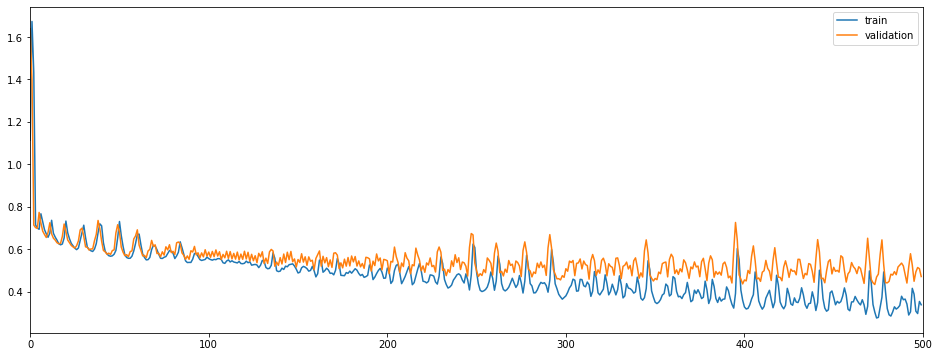

In [72]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, 500)
plt.show()

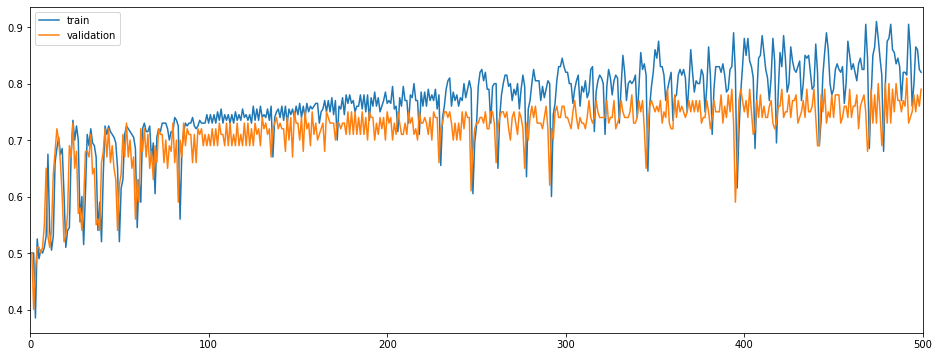

In [73]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, 500)
plt.show()

In [74]:
model = define_model_architecture()
%time history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=100, batch_size=200, shuffle=True)

Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 0s 553us/sample - loss: 1.0408 - accuracy: 0.5050 - val_loss: 0.8052 - val_accuracy: 0.5100
Epoch 2/100
200/200 [==============================] - 0s 57us/sample - loss: 0.8117 - accuracy: 0.5050 - val_loss: 0.7354 - val_accuracy: 0.5000
Epoch 3/100
200/200 [==============================] - 0s 56us/sample - loss: 0.7415 - accuracy: 0.5000 - val_loss: 0.7148 - val_accuracy: 0.5200
Epoch 4/100
200/200 [==============================] - 0s 58us/sample - loss: 0.7142 - accuracy: 0.5050 - val_loss: 0.6955 - val_accuracy: 0.5300
Epoch 5/100
200/200 [==============================] - 0s 76us/sample - loss: 0.6958 - accuracy: 0.5500 - val_loss: 0.6928 - val_accuracy: 0.4500
Epoch 6/100
200/200 [==============================] - 0s 59us/sample - loss: 0.6924 - accuracy: 0.4950 - val_loss: 0.6905 - val_accuracy: 0.5200
Epoch 7/100
200/200 [==============================] - 0s 57us/sample - loss:

Epoch 57/100
200/200 [==============================] - 0s 63us/sample - loss: 0.5894 - accuracy: 0.6700 - val_loss: 0.6099 - val_accuracy: 0.6900
Epoch 58/100
200/200 [==============================] - 0s 56us/sample - loss: 0.5953 - accuracy: 0.7100 - val_loss: 0.5847 - val_accuracy: 0.6300
Epoch 59/100
200/200 [==============================] - 0s 54us/sample - loss: 0.5755 - accuracy: 0.6900 - val_loss: 0.6030 - val_accuracy: 0.7000
Epoch 60/100
200/200 [==============================] - 0s 51us/sample - loss: 0.5850 - accuracy: 0.7100 - val_loss: 0.5937 - val_accuracy: 0.6300
Epoch 61/100
200/200 [==============================] - 0s 57us/sample - loss: 0.5787 - accuracy: 0.6800 - val_loss: 0.6190 - val_accuracy: 0.6600
Epoch 62/100
200/200 [==============================] - 0s 45us/sample - loss: 0.6039 - accuracy: 0.7050 - val_loss: 0.5845 - val_accuracy: 0.6400
Epoch 63/100
200/200 [==============================] - 0s 49us/sample - loss: 0.5832 - accuracy: 0.6750 - val_loss: 0

label for example : [0. 1.]


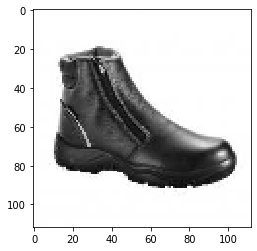

In [75]:
example_ix = 125
image_2d_array = X_train[example_ix].reshape(112,112)
imshow(image_2d_array,cmap="gray")
print('label for example : %s' % y_train[example_ix])

In [76]:
stats.describe(X_train[example_ix])

DescribeResult(nobs=12544, minmax=(0.05882353, 1.0), mean=0.7790194, variance=0.10948922, skewness=-0.953533947467804, kurtosis=-0.942356327021916)

In [77]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

50/50 [==============================] - 0s 633us/sample - loss: 0.5480 - accuracy: 0.6800
Test loss: 0.5480 accuracy: 0.6800


In [78]:
le.inverse_transform([0,1])

array(['cap', 'shoes'], dtype='<U5')

In [79]:
predictions = model.predict(X_test)
test_prediction_data = pd.DataFrame(np.hstack([predictions,y_test]).astype("float16"), columns=['predicted_cap','predicted_shoes','actual cap','actual_shoes'])
test_prediction_data[:5]

,predicted_cap,predicted_shoes,actual cap,actual_shoes
0,0.899902,0.100037,1.0,0.0
1,0.950195,0.049805,1.0,0.0
2,0.959473,0.040375,1.0,0.0
3,0.812012,0.188232,1.0,0.0
4,0.978516,0.021454,1.0,0.0


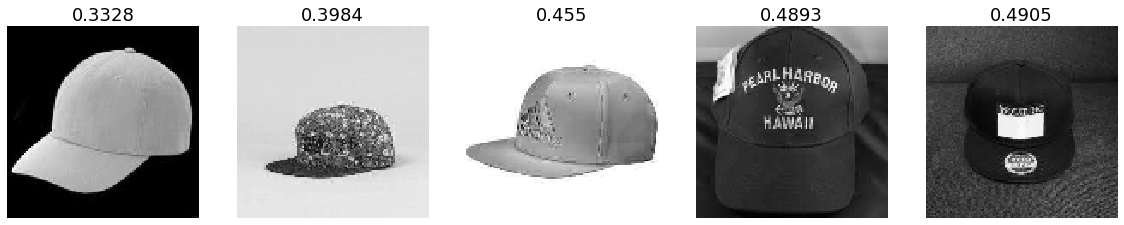

In [80]:
top_wrong_caps_ix = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values().index.values[:5]
top_wrong_caps_values = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values().values[:5]
plot_images(X_test[top_wrong_caps_ix],titles=top_wrong_caps_values)

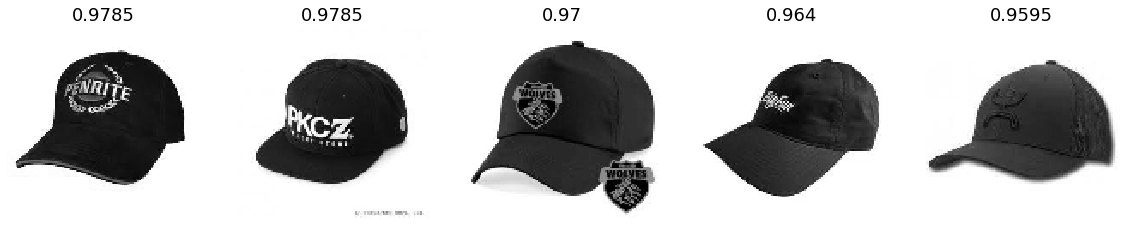

In [81]:
top_correct_caps_ix = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values(ascending=False).index.values[:5]
top_correct_caps_values = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values(ascending=False).values[:5]
plot_images(X_test[top_correct_caps_ix],titles=top_correct_caps_values)

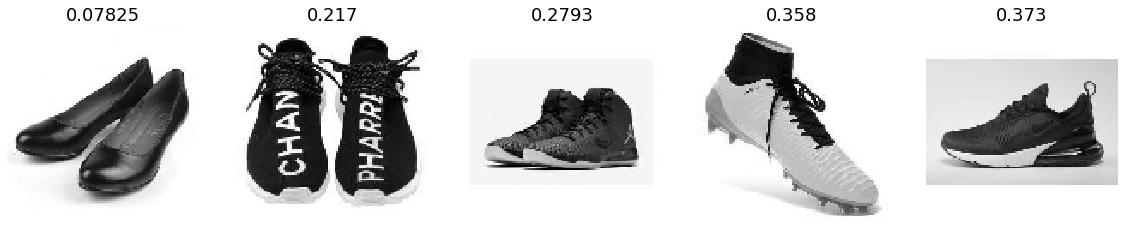

In [82]:
top_wrong_shoes_ix = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values().index.values[:5]
top_wrong_shoes_values = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values().values[:5]
plot_images(X_test[top_wrong_shoes_ix],titles=top_wrong_shoes_values)

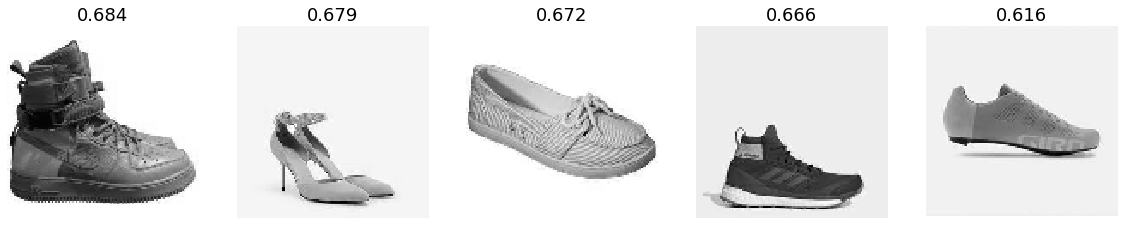

In [83]:
top_correct_shoes_ix = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values(ascending=False).index.values[:5]
top_correct_shoes_values = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values(ascending=False).values[:5]
plot_images(X_test[top_correct_shoes_ix],titles=top_correct_shoes_values)

actual label for example : [0. 1.]
predicted label for example : [0.4036 0.596 ]


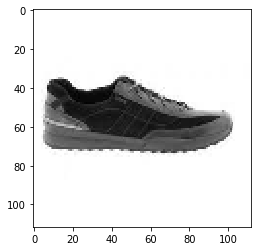

In [84]:
test_ix = 43
image_2d_array = X_test[test_ix].reshape(112,112)
imshow(image_2d_array,cmap="gray")
print('actual label for example : %s' % y_test[test_ix])
print('predicted label for example : %s' % np.array(predictions[test_ix]).astype("float16"))

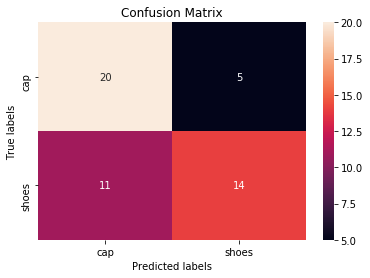

In [85]:
labels = ['cap','shoes']
cm = confusion_matrix(np.argmax(y_test ,axis=1), np.argmax(predictions, axis=1), [0,1])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

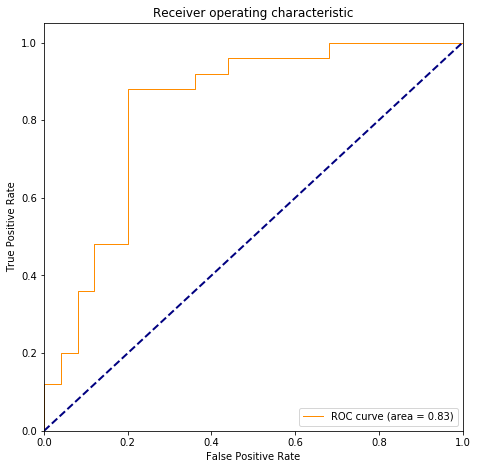

In [86]:
fpr, tpr, thresholds = roc_curve(y_test[:,1], predictions[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

[[0.33704278 0.6629572 ]]
I think what I see is : shoes 


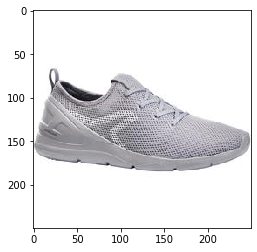

In [88]:
#TEST_IMAGE_URL = 'https://www.usjcycles.com/v3/wp-content/uploads/2017/05/castelli-team-sky-cycling-cap.jpg'
TEST_IMAGE_URL = 'https://contents.mediadecathlon.com/p1419921/k$72b461620e3e5ec61db942355362dd66/pw-100-men-s-fitness-walking-shoes-grey.jpg?&f=250x250'
#TEST_IMAGE_URL = 'https://5.imimg.com/data5/DA/JA/MY-7083094/ladies-party-wear-frock-500x500.jpg'
test_image = url_to_image(TEST_IMAGE_URL)
imshow(test_image)

test_image_data = convert_img_to_data(test_image)
test_image_data = test_image_data.astype('float32') / 255
test_image_data = test_image_data.reshape(1,12544)

predicted_output = model.predict(test_image_data)
print(predicted_output)
print('I think what I see is : %s ' % le.inverse_transform(np.argmax(predicted_output, axis=1))[0])